In [13]:
from kaggle_environments import make, utils
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
env = make("connectx", debug=True)
env.render(mode="ipython")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
class CNN(nn.Module):
    def __init__(self, outputs=7):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(192, 32)
        self.head = nn.Linear(32, outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = self.head(x)
        return x

In [5]:
class DQNAgent():
    def __init__(self, env, lr=1e-2, min_experiences=100, max_experiences=10_000, channel=1):
        self.env = env
        self.model = CNN() # 価値評価用のCNN
        self.teacher_model = CNN() # 遷移先価値評価用のCNN
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.experience = {'s': [], 'a': [], 'r': [], 'n_s': [], 'done': []} # 行動履歴
        self.min_experiences = min_experiences
        self.max_experiences = max_experiences
        self.actions = list(range(self.env.configuration.columns))
        self.col_num = self.env.configuration.columns
        self.row_num = self.env.configuration.rows
        self.channel = channel
        
    def add_experience(self, exp):
        # 行動履歴の更新
        if len(self.experience['s']) >= self.max_experiences:
            # 行動履歴のサイズが大きすぎる時は古いものを削除
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)
        
        
    def preprocess(self, state):
        # 状態は自分のチェッカーを1, 相手のチェッカーを0.5とした7x6多次元配列で表す
        result = np.array(state.board[:])
        result = result.reshape([self.col_num, self.row_num])
        if state.mark == 1:
            return np.where(result == 2, 0.5, result)
        else:
            result = np.where(result == 2, 1, result)
            return np.where(result == 1, 0.5, result)
    
    def estimate(self, state):
        # 価値の計算
        return self.model(
            torch.from_numpy(state).view(-1, self.channel, self.col_num, self.row_num).float()
        ) 
    
    def future(self, state):
        # 遷移先の価値の計算
        return self.teacher_model(
            torch.from_numpy(state).view(-1, self.channel, self.col_num, self.row_num).float()
        )
    
    def policy(self, state, epsilon):
        # 状態から、CNNの出力に基づき、次の行動を選択
        if np.random.random() < epsilon:
            # 探索
            return int(np.random.choice([c for c in range(len(self.actions)) if state.board[c] == 0]))
        else:
            # Actionの価値を取得
            prediction = self.estimate(self.preprocess(state))[0].detach().numpy()
            for i in range(len(self.actions)):
                # ゲーム上選択可能なactionに絞る
                if state.board[i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))
    
    def update(self, gamma):
        # 行動履歴が十分に蓄積されているか
        if len(self.experience['s']) < self.min_experiences:
            return 
        
        # 行動履歴から学習用のデータのidをサンプリングする
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=32)
        states = np.asarray([self.preprocess(self.experience['s'][i]) for i in ids])
        states_next = np.asarray([self.preprocess(self.experience['n_s'][i]) for i in ids])
        
        # 価値の計算
        estimateds = self.estimate(states).detach().numpy() # 見積もりの価値
        future = self.future(states_next).detach().numpy() # 遷移先の価値
        target = estimateds.copy()
        for idx, i in enumerate(ids):
            a = self.experience['a'][i]
            r = self.experience['r'][i]
            d = self.experience['done'][i]
            reward = r
            if not d:
                reward += gamma * np.max(future[idx])
        # TD誤差を小さくするようにCNNを更新
        self.optimizer.zero_grad()
        loss = self.criterion(torch.tensor(estimateds, requires_grad=True),
                              torch.tensor(target, requires_grad=True))
        loss.backward()
        self.optimizer.step()
        
    def update_teacher(self):
        # 遷移先の価値の更新
        self.teacher_model.load_state_dict(self.model.state_dict())

In [6]:
class DQNTrainer():
    def __init__(self, env):
        self.epsilon = 0.9
        self.env = env
        self.agent = DQNAgent(env)
        self.reward_log = []
    
    def custom_reward(self, reward, done):
        # Clipping
        if done:
            if reward == 1: # 勝ち
                return 1
            elif reward == 0: # 負け
                return -1
            else: # 引き分け
                return 0
        else:
            return 0 # 勝負がついてない
        
    def train(self, trainer,epsilon_decay_rate=0.9999, min_epsilon=0.1, episode_cnt=100, gamma=0.6):
        iter = 0
        for episode in tqdm(range(episode_cnt)):
            rewards = []
            state = trainer.reset() # ゲーム環境リセット
            self.epsilon = max(min_epsilon, self.epsilon * epsilon_decay_rate) # epsilonを徐々に小さくする
            while not env.done: 
                # どの列にドロップするか決める
                action = self.agent.policy(state, self.epsilon)
                prev_state = state
                state, reward, done, _ = trainer.step(action) 
                reward = self.custom_reward(reward, done)
                # 行動履歴の蓄積
                exp = {'s': prev_state, 'a': action, 'r': reward, 'n_s': state, 'done': done}
                self.agent.add_experience(exp)
                # 価値評価の更新
                self.agent.update(gamma)
                iter += 1
                if iter % 100 == 0:
                    # 遷移先価値計算用の更新
                    self.agent.update_teacher()
            self.reward_log.append(reward)

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [1:29:40<00:00,  5.58it/s]


<AxesSubplot:>

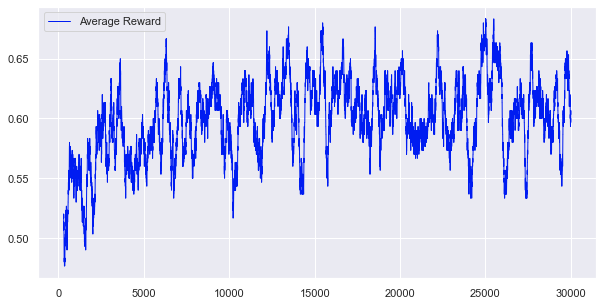

In [14]:
trainer = env.train([None, "random"])
dq = DeepQNetworkTrainer(env)
dq.train(trainer, episode_cnt=30000)

# 結果の描画
import seaborn as sns
sns.set()

sns.set_palette("winter", 8)
sns.set_context({"lines.linewidth": 1})
pd.DataFrame({'Average Reward': dq.reward_log}).rolling(300).mean().plot(figsize=(10,5))

In [20]:
torch.save(dq.agent.model.state_dict(), "dqn_model_weights.pth")